In [40]:
pip install tiktoken

Note: you may need to restart the kernel to use updated packages.


In [41]:
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader

In [42]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        # assert (d_out % num_heads == 0), 
        #     "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = torch.nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = torch.nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [43]:
class GELU(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [44]:
class Feed_Forward(torch.nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(cfg['emb_dim'],4*cfg['emb_dim']),
            GELU(),
            torch.nn.Linear(4*cfg['emb_dim'],cfg['emb_dim'])
        )

    def forward(self,x):
        return self.layer(x)

In [45]:
class Layer_Norm(torch.nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.eps = 6e-8
        self.scale = torch.nn.Parameter(torch.ones(emb_dim))
        self.shift = torch.nn.Parameter(torch.zeros(emb_dim))
    def forward(self,x):
        mean = x.mean(dim=-1,keepdim = True)
        var = x.var(dim = -1,keepdim = True)
        out = (x - mean)/torch.sqrt(var + self.eps)
        out = out * self.scale + self.shift

        return out

In [46]:
class Transformer(torch.nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.attn = MultiHeadAttention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],#this will be the context vector dim for each token
            context_length= cfg['context_length'],#total no of tokens in the input sequence
            dropout=cfg['drop_rate'],
            num_heads= cfg['n_heads'],
            qkv_bias=cfg['qkv_bias']
        )
        self.ff = Feed_Forward(cfg)
        self.norm_1 = Layer_Norm(cfg['emb_dim'])
        self.norm_2 = Layer_Norm(cfg['emb_dim'])
        self.dropout_shortcut = torch.nn.Dropout(cfg['drop_rate'])

    def forward(self,x):
        shortcut = x
        x = self.norm_1(x)
        x = self.attn(x)
        x = self.dropout_shortcut(x)
        x = x + shortcut
        # now ff
        shortcut = x
        x = self.norm_2(x)
        x = self.ff(x)
        x = self.dropout_shortcut(x)
        x = x+shortcut

        return x
        
        
    

In [47]:
class GPT_Model(torch.nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.tok_emb = torch.nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
        self.pos_emb = torch.nn.Embedding(cfg['context_length'],cfg['emb_dim'])
        self.dropout = torch.nn.Dropout(cfg['drop_rate'])
        self.tranformer = torch.nn.Sequential(
            *[
               Transformer(cfg) for _ in range(self.cfg['n_layers'])
            ]
        )
        self.out_norm = Layer_Norm(cfg['emb_dim'])
        self.out_head = torch.nn.Linear(cfg['emb_dim'],cfg['vocab_size'],bias=False)


    def forward(self,inp_idx):
        batch,seq_len = inp_idx.shape#batch means no of seq and seqlen means no of tokens in each seq
        x = self.tok_emb(inp_idx)
        x_pos = self.pos_emb(torch.arange(seq_len,device=inp_idx.device))
        x = x+x_pos
        x = self.dropout(x)
        x = self.tranformer(x)
        x = self.out_norm(x)
        logits = self.out_head(x)
        return logits

In [48]:

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))#appends to the list the input chunk which is a tensor of length max_length
            self.target_ids.append(torch.tensor(target_chunk))#output chunk start from input start + 1 with length max_length

            # in another iteration the another input and output chunk will be added to the list

    def __len__(self):
        
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [49]:
def create_dataLoader(txt,batch_size=4, stride=256, max_length=256,Shuffle=True,drop_last=True,num_workers=0):
    tokenizer  = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    # print(dataset[0])
    dataLoader = DataLoader(
        dataset,
        batch_size=batch_size,# this tells in a batch how many sequences will be there if it is 4 then it will have 4 sequences in a batch means 4 input sequences and 4 output sequences
        shuffle=Shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    return dataLoader
    


In [50]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length is the length of the input sequence means no of tokens in each input sequence
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [51]:
# with open ('the-verdict.txt', 'r') as f:
#     text = f.read()
# data_loader = create_dataLoader(text, batch_size=2, stride=256, max_length=256,Shuffle=True,drop_last=True,num_workers=0)

# data_iter = iter(data_loader)#it will make a iteration of the data loader and returns a iterator
# # to acess the data we need to use next

# print(next(data_iter))


In [52]:
#Train/Validate split
rate = 0.9
with open ('the-verdict.txt') as file:
    txt = file.read()

train = int(0.9*len(txt))
print(len(txt),train)

train_data = txt[:train]
validate_data = txt[train:]
# # print(train_data)
# print(validate_data)


20479 18431


In [53]:
torch.manual_seed(123)
train_loader = create_dataLoader(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length']
)

validate_loader = create_dataLoader(
    validate_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length']
)

In [54]:
# print(train_loader)

In [55]:
for x,y in train_loader:
    print(x.shape)
    print(y.shape)
    print("next")



torch.Size([2, 256])
torch.Size([2, 256])
next
torch.Size([2, 256])
torch.Size([2, 256])
next
torch.Size([2, 256])
torch.Size([2, 256])
next
torch.Size([2, 256])
torch.Size([2, 256])
next
torch.Size([2, 256])
torch.Size([2, 256])
next
torch.Size([2, 256])
torch.Size([2, 256])
next
torch.Size([2, 256])
torch.Size([2, 256])
next
torch.Size([2, 256])
torch.Size([2, 256])
next
torch.Size([2, 256])
torch.Size([2, 256])
next


In [56]:
print("validation loader")
for x,y in validate_loader:
 
    print(x.shape)
    print(y.shape)
    print("next")

validation loader
torch.Size([2, 256])
torch.Size([2, 256])
next


In [57]:
print(len(train_loader))
print(len(validate_loader))

9
1


In [58]:
def calc_batch_loss(input_batch,target_batch,model,device):
    input_batch,target_batch = input_batch.to(device),target_batch.to(device)
    logits = model(input_batch)#for a batch there can have multiple input sequence of inputs which are sent to model class and we get input in batch_size*no_of_tokens_in_one_sequence*vocab_size
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1),target_batch.flatten())#target was 2*256 before flatten
    return loss

In [ ]:
def calc_loader_loss(data_loader,model,device,num_batches=None):
    train_loss =0 
    if(len(data_loader)==0):
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)#it gives no of batches in a dataloader where in each batch there are multiple input and target sequences
        # we will have avg loss of these input sequences among different loss
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss = calc_batch_loss(input_batch=input_batch,target_batch=target_batch,model=model,device=device)
            #this batch are the one from one batch which are of dim 2*256 which will later in model will be done a vector embedding of dim 768 for each token to get each batch have dimension of 2*256*768 and later inside same model it will return 2*256*50257 returned as logits and these will be performed softmax where each toke have vector for every vocabloury  and then highest probablity token is chosen as output for each input token 
            train_loss +=loss

        else:
            break

    return train_loss/num_batches

<div class="alert alert-block alert-info">

If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code.
    
Via the device setting, we ensure that the data is loaded onto the same device as the LLM model.
    
</div>

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT_Model(cfg=GPT_CONFIG_124M)
# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loader_loss(train_loader, model, device)
    val_loss = calc_loader_loss(validate_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using cuda device.
Training loss: tensor(10.9644, device='cuda:0')
Validation loss: tensor(10.9756, device='cuda:0')


In [61]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loader_loss(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [62]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]#takes only last context size tokens as input in each batch
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)# gets batch*no_tokens*vocab_size
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  #takes only the last row of input sequence

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)
        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)#appens the output token to input and iterate again to predict nexxt one

    return idx

<div class="alert alert-block alert-success">

We can now apply the temperature scaling and multinomial function for probabilistic
sampling introduced in the previous section to select the next token among these 3 nonzero probability scores to generate the next token. We do this in the next section by
modifying the text generation function.

</div>

<div class="alert alert-block alert-info">

Step 1: For-loop is the same as before: Get logits, and only focus on last time step

Step 2: In this new section, we filter logits with top_k sampling

Step 3: This is the new section where we apply temperature scaling
    
Step 4: Carry out greedy next-token selection as before when temperature scaling is disabled

Step 5: Stop generating early if end-of-sequence token is encountered and eos_id is specified

</div>

In [63]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)#batches,no_of_token,vocab_size
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [64]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    print(flat)
    return tokenizer.decode(flat.tolist())

# start_context = "Every effort moves you"
# tokenizer = tiktoken.get_encoding("gpt2")

# token_ids = generate_text_simple(
#     model=model,
#     idx=text_to_token_ids(start_context, tokenizer),
#     max_new_tokens=10,
#     context_size=GPT_CONFIG_124M["context_length"]
# )

# print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

In [65]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [66]:
# pre trainning the llm model 
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_batch_loss(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

        # torch.save({
        #     "model_state_dict": model.state_dict(),
        #     "optimizer_state_dict": optimizer.state_dict(),
        #     }, 
        #     "model_and_optimizer.pth"
        #         )

    return train_losses, val_losses, track_tokens_seen

In [67]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loader_loss(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [68]:
tokenizer = tiktoken.get_encoding("gpt2")

In [69]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPT_Model(GPT_CONFIG_124M)

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, validate_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.822, Val loss 9.932
Ep 1 (Step 000005): Train loss 7.924, Val loss 8.335
tensor([6109, 3626, 6100,  345,   11,   11,   11,   11,   11,   11,   11,   11,
          11,   11,   11,   11,   11,   11,   13,  198,  198,  198,  198,  198,
         198,  198,  198,  198,  198,  198,  198,  198,  198,  198,  198,  198,
         198,  198,  198,  198,  198,  198,  198,  198,  198,  198,  198,  198,
         198,  198,  198,  198,  198,  198], device='cuda:0')
Every effort moves you,,,,,,,,,,,,,,.                                   
Ep 2 (Step 000010): Train loss 6.586, Val loss 7.043
Ep 2 (Step 000015): Train loss 5.987, Val loss 6.592
tensor([6109, 3626, 6100,  345,   11,  262,   11,  262,  286,  262,   11,  262,
          11,  262,   11,  262,   13,  198,    1,   11,  262,   11,  262,   11,
          11,   11,  262,   11,  290,   11,  262,   11,   11,  262,   11,   11,
         262,   11,  290,   11,  262,   11,  262,   11,   11,  262,   11,  262,
          11,

In [70]:
pip install matplotlib

  Using cached matplotlib-3.10.8-cp311-cp311-win_amd64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp311-cp311-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.3.1-py3-none-any.whl.metadata (5.6 kB)
Using cached matplotlib-3.10.8-cp311-cp311-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl (225 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp311-cp311-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp311-cp311-win_amd64.whl (73 kB)
Using cached pyparsing-3.3.1-py3-none-any.whl (121 kB)

   ---------------------------------------- 0/6 [pyparsing]
   ------ --------------------------------- 1/6 [kiwisolver]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

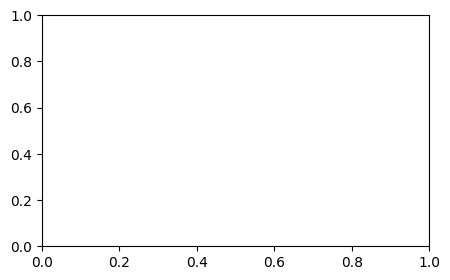

In [71]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    # plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
import torch

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4050 Laptop GPU


In [ ]:
# pip install torch torchvision torchaudio -y
# %pip install torch --quiet

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

torch.Size([1, 4, 50257])
torch.Size([1, 5, 50257])
torch.Size([1, 6, 50257])
torch.Size([1, 7, 50257])
torch.Size([1, 8, 50257])
torch.Size([1, 9, 50257])
torch.Size([1, 10, 50257])
torch.Size([1, 11, 50257])
torch.Size([1, 12, 50257])
torch.Size([1, 13, 50257])
torch.Size([1, 14, 50257])
torch.Size([1, 15, 50257])
torch.Size([1, 16, 50257])
torch.Size([1, 17, 50257])
torch.Size([1, 18, 50257])
tensor([6109, 3626, 6100,  345,  772, 8812,  558,   13,  198,  198,  198,  198,
           1,  339,   11,  530,  416,  262, 4469])
Output text:
 Every effort moves you even terrace.



" he, one by the background


*italicized text*<div class="alert alert-block alert-success">

Fortunately, saving a PyTorch model is relatively straightforward. 

The recommended way is to save a model's so-called state_dict, a dictionary mapping each layer to its parameters,
using the torch.save function as follows:
</div>

In [ ]:
model = GPT_Model(GPT_CONFIG_124M)
torch.save(model.state_dict(), "model.pth")

In [ ]:
model = GPT_Model(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPT_Model(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (tranformer): Sequential(
    (0): Transformer(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): Feed_Forward(
        (layer): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm_1): Layer_Norm()
      (norm_2): Layer_Norm()
      (dropout_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): Transformer(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=

<div class="alert alert-block alert-success">

Adaptive optimizers such as AdamW store additional parameters for each model weight.
AdamW uses historical data to adjust learning rates for each model parameter dynamically.
                                                   
Without it, the optimizer resets, and the model may learn suboptimally or even fail to
converge properly, which means that it will lose the ability to generate coherent text. 

Using
torch.save, we can save both the model and optimizer state_dict contents as follows:
</div>

In [ ]:
#we can save the model and optimizer 
# best place to save model and optimizer is after each epoch in trainning so later when we again train it starts from that epoch so it becomes fast
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

checkpoint = torch.load("model_and_optimizer.pth")
model = GPT_Model(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()
#now we can train from the checkpoint
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, validate_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)


GPT_Model(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (tranformer): Sequential(
    (0): Transformer(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): Feed_Forward(
        (layer): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm_1): Layer_Norm()
      (norm_2): Layer_Norm()
      (dropout_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): Transformer(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=

In [ ]:
### Loading pretrainned gpt wei

In [ ]:
from gpt_download import download_and_load_gpt2

d:\repos\llms\LLMs\llms\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

d:\repos\llms\LLMs\llms\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
models\124M\checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 77.0kiB/s]
d:\repos\llms\LLMs\llms\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
models\124M\encoder.json: 100%|██████████| 1.04M/1.04M [00:03<00:00, 282kiB/s] 
d:\repos\llms\LLMs\llms\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blo

In [ ]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [74]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


## this shows us that this embedding parameters are correctly loaded and has same shape as we defined now instead of randomly definning paarameters we can now use these parameter in each block and layers to get better results

In [72]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [73]:
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
gpt = GPT_Model(NEW_CONFIG)
gpt.eval();

<div class="alert alert-block alert-success">
    
By default, the GPTModel instance is initialized with random weights for pretraining. 

The last
step to using OpenAI's model weights is to override these random weights with the weights
we loaded into the params dictionary.

For this, we will first define a small assign utility function that checks whether two
tensors or arrays (left and right) have the same dimensions or shape and returns the
right tensor as trainable PyTorch parameters:
</div>

In [75]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

<div class="alert alert-block alert-info">

Step 1: Setting the model's positional and token embedding weights to those specified in params.

Step 2: Iterate over each transformer block in the model.

Step 3: The np.split function is used to divide the attention and bias weights into three equal parts for the query,
key, and value components.
    
Step 4: The original GPT-2 model by OpenAI reused the token embedding weights in the output layer to reduce the
total number of parameters, which is a concept known as weight tying.

</div>

In [89]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.tranformer[b].attn.W_query.weight = assign(
            gpt.tranformer[b].attn.W_query.weight, q_w.T)
        gpt.tranformer[b].attn.W_key.weight = assign(
            gpt.tranformer[b].attn.W_key.weight, k_w.T)
        gpt.tranformer[b].attn.W_value.weight = assign(
            gpt.tranformer[b].attn.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.tranformer[b].attn.W_query.bias = assign(
            gpt.tranformer[b].attn.W_query.bias, q_b)
        gpt.tranformer[b].attn.W_key.bias = assign(
            gpt.tranformer[b].attn.W_key.bias, k_b)
        gpt.tranformer[b].attn.W_value.bias = assign(
            gpt.tranformer[b].attn.W_value.bias, v_b)

        gpt.tranformer[b].attn.out_proj.weight = assign(
            gpt.tranformer[b].attn.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.tranformer[b].attn.out_proj.bias = assign(
            gpt.tranformer[b].attn.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.tranformer[b].ff.layer[0].weight = assign(
            gpt.tranformer[b].ff.layer[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.tranformer[b].ff.layer[0].bias = assign(
            gpt.tranformer[b].ff.layer[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.tranformer[b].ff.layer[2].weight = assign(
            gpt.tranformer[b].ff.layer[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.tranformer[b].ff.layer[2].bias = assign(
            gpt.tranformer[b].ff.layer[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.tranformer[b].norm_1.scale = assign(
            gpt.tranformer[b].norm_1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.tranformer[b].norm_1.shift = assign(
            gpt.tranformer[b].norm_1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.tranformer[b].norm_2.scale = assign(
            gpt.tranformer[b].norm_2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.tranformer[b].norm_2.shift = assign(
            gpt.tranformer[b].norm_2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.out_norm.scale = assign(gpt.out_norm.scale, params["g"])
    gpt.out_norm.shift = assign(gpt.out_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



<div class="alert alert-block alert-success">

In the load_weights_into_gpt function, we carefully match the weights from OpenAI's
implementation with our GPTModel implementation. 

To pick a specific example, OpenAI
stored the weight tensor for the output projection layer for the first transformer block as
params["blocks"][0]["attn"]["c_proj"]["w"]. 
                                                        
In our implementation, this weight
tensor corresponds to gpt.trf_blocks[b].att.out_proj.weight, where gpt is a
GPTModel instance.
</div>

In [90]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("nepal is good ", tokenizer).to(device),
    max_new_tokens=100,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

NameError: name 'torch' is not defined

In [92]:
print(device)

cuda
